https://blog.keras.io/building-autoencoders-in-keras.html

# Import Libraries

In [ ]:
# jax
import jax
import numpy as np
import jax.numpy as jnp
from jax import tree_util
import optax

# sklearn
from sklearn.metrics import mean_squared_error

# General
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

# keras
import keras
from keras import layers
from keras import backend as K
from keras.models import Model

# tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/augmented_data.csv")
val_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/val_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/test_data.csv")

In [ ]:
X_train = train_df.drop(['label'], axis=1)
y_train = train_df['label']
X_val = val_df.drop(['label'], axis=1)
y_val = val_df['label']
X_test = test_df.drop(['label'], axis=1)
y_test = test_df['label']

In [ ]:
x_train = np.reshape(X_train.to_numpy(), (X_train.shape[0], X_train.shape[1]))
x_train = np.reshape(x_train, (x_train.shape[0], 64, 64, 1))

In [ ]:
x_train.shape

(9240, 64, 64, 1)

In [ ]:
x_test = np.reshape(X_test.to_numpy(), (X_test.shape[0], X_test.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 64, 64, 1))
x_val = np.reshape(X_val.to_numpy(), (X_val.shape[0], X_val.shape[1]))
x_val = np.reshape(x_val, (x_val.shape[0], 64, 64, 1))

# Denoise Autoencoder

In [ ]:
# Add Gaussian noise (mean = 0, variance = 1) - standard normal distribution
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

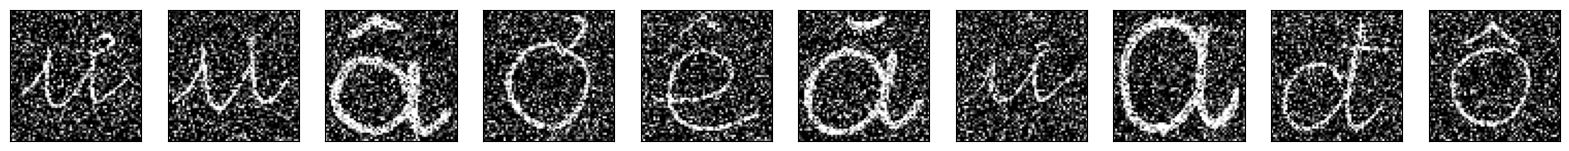

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
input_img = keras.Input(shape=(64, 64, 1))

# Add two convolutional layers as the encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Add  two convolutional layers as the decoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x) # Increase spatial dimension of feature map
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x) # Increase spatial dimension of feature map

decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Build model using adam optimizer and binary cross-entropy because our pixel value is binarized
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

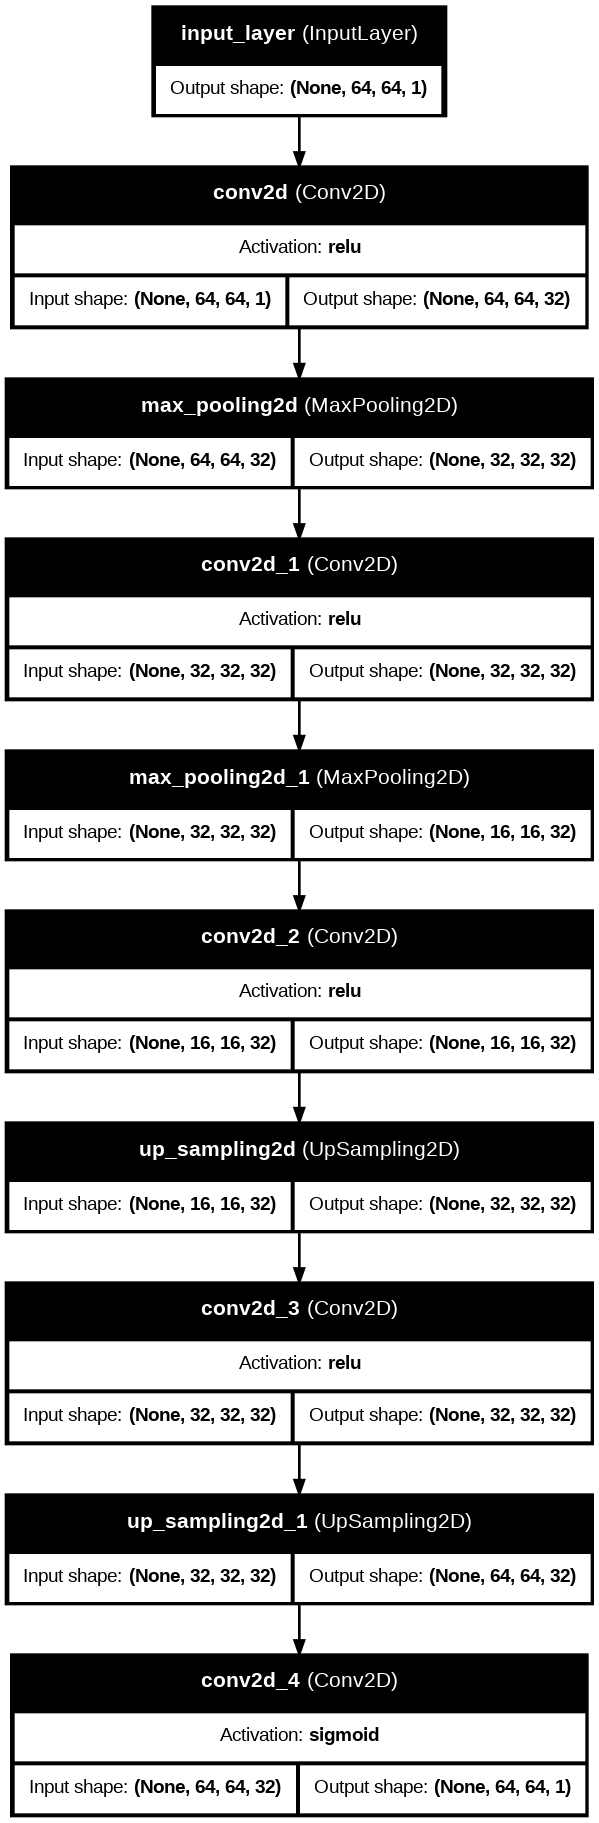

In [ ]:
# Draw the model architecture
keras.utils.plot_model(
    autoencoder,
    to_file='autoencoder_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=96,
    show_layer_activations=True
)

In [ ]:
start_train_time = time.time()
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val_noisy, x_val),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])
end_train_time = time.time()

Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - loss: 0.1340 - val_loss: 0.0902
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 0.1248 - val_loss: 0.0795
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - loss: 0.1204 - val_loss: 0.0736
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - loss: 0.1151 - val_loss: 0.0743
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - loss: 0.1137 - val_loss: 0.0689
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - loss: 0.1115 - val_loss: 0.0760
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - loss: 0.1119 - val_loss: 0.0672
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - loss: 0.1100 - val_loss: 0.0678
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - loss: 0.1087 - val_loss: 0.0636
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - loss: 0.1091 - val_loss: 0.0630


In [ ]:
total_train_time = end_train_time - start_train_time
print("Total training time:", total_train_time, "seconds")

Total training time: 1365.6679623126984 seconds


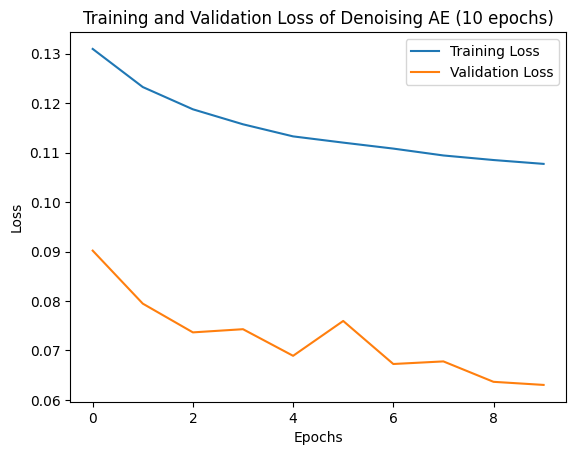

In [ ]:
# Plot val and train loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss of Denoising AE (10 epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
start_test_time = time.time()
test_loss = autoencoder.evaluate(x_test_noisy, x_test, batch_size=128)
end_test_time = time.time()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0625


In [ ]:
print("Total Test Time:", end_test_time - start_test_time, "seconds")

Total Test Time: 0.6113381385803223 seconds


In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


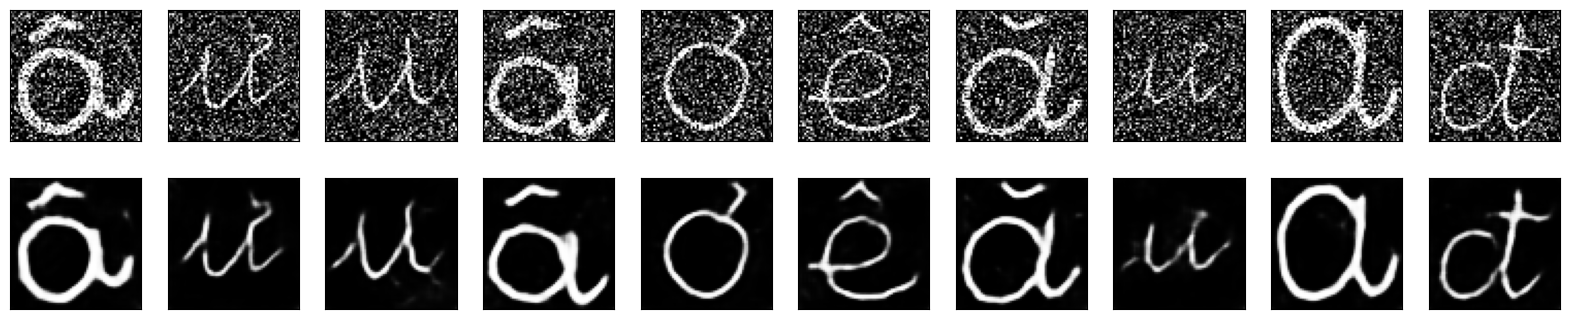

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)  # Reshape to (num_samples, num_features)
decoded_imgs_reshaped = decoded_imgs.reshape(decoded_imgs.shape[0], -1)  # Reshape predictions

In [ ]:
test_loss = np.mean(tf.keras.losses.binary_crossentropy(x_test_reshaped, decoded_imgs_reshaped))

In [ ]:
test_loss = mean_squared_error(x_test_reshaped, decoded_imgs_reshaped)

In [ ]:
print("Test Loss:", test_loss)

Test Loss: 0.013467157424601554
